# Part 3: Data Cleaning and Exploratory Data Analysis

---

## Notebook Summary

This notebook shows the reader how the posts from our two different subreddits, r/ADHD and r/autism, were cleaned and then investigated in initial exploratory data analysis (EDA). In our problem statement, the reader will recall that we are hoping to classify the personal testimony text of a person who believes that they may be neurodiverse but is unsure whether they are more likely living with ADHD or autism. Since this model relies on how people living with these neurodiverse conditions describe their own lived experiences in their own words, it is imperative that in the data cleaning and data analysis that we look for word, phrase, and sentiment frequencies which most closely mimic the way a lay person might talk, not a medical expert. Included in this notebook, the reader will find:

* Initial Data Cleaning
* Post Length EDA
* Word and Phrase EDA
* Sentiment EDA
* Notebook Conclusion

---

## Initial Data Cleaning

First, we will import the requisite Python libraries for data cleaning, visualizations, and natural language processing. Then, we will read in the subreddit posts data frame and begin cleaning the data.

In [1]:
# import requisite libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# read in the subreddit posts dataset compiled during data collection
subreddit_posts = pd.read_csv('./data_files/subreddit_posts.csv')

# print the current shape of the dataset
print(subreddit_posts.shape)

# print the df head to preview the data
subreddit_posts.head()

(19871, 3)


,title,selftext,subreddit
0,Megathread: US Medication Shortage,"As many of you are aware by now, the current U...",ADHD
1,Did you do something you're proud of? Somethin...,What success have you had this week?\n\nDid yo...,ADHD
2,The Vyvanse poops have taken over my mornings..,I now wake up at least 1.5 hours early to ensu...,ADHD
3,Why does someone forcing you to push through e...,I can’t even explain how it hurts but it’s so ...,ADHD
4,Just had an epiphany- isn’t it crazy how relig...,"So my mom can believe in all her saints, God, ...",ADHD


First, we will need to check for any duplicate posts. Since the Reddit API has added new restrictions on only collecting the most recent 1,000 posts from any one subreddit at a time, we will very likely have duplicate posts collected when we run our script roughly every 24 hours or so. Based on this most recently saved file of our post data, we have 19,981 posts in total. This is very unlikely, so we will begin by dropping duplicates.

In [3]:
# drop any duplicate posts in the dataset
subreddit_posts.drop_duplicates(inplace = True, ignore_index = True)

In [4]:
# preview the dataset without duplicates to show total unique posts collected
subreddit_posts

,title,selftext,subreddit
0,Megathread: US Medication Shortage,"As many of you are aware by now, the current U...",ADHD
1,Did you do something you're proud of? Somethin...,What success have you had this week?\n\nDid yo...,ADHD
2,The Vyvanse poops have taken over my mornings..,I now wake up at least 1.5 hours early to ensu...,ADHD
3,Why does someone forcing you to push through e...,I can’t even explain how it hurts but it’s so ...,ADHD
4,Just had an epiphany- isn’t it crazy how relig...,"So my mom can believe in all her saints, God, ...",ADHD
...,...,...,...
4863,Scared of old people,Anyone else scared of old people? When I talk ...,autism
4864,Recommendations for blocking out noise for sleep,I have a really hard time sleeping due to even...,autism
4865,Mom Refuses Access to Diagnosis Report,I (17F) was diagnosed with autism and ADHD aro...,autism
4866,Do you feel uncomfortable with everyday sounds?,"I'm talking about inevitable sounds, as:\nbird...",autism


As suspected, after dropping duplicates, it appears that there are really only 4,868 unique posts collected from our webscraper script's multiple executions over the past week or so. As a reminder, the reader may refer to our transaction log to review the history of dates, times, and number of posts collected in running out script.

Next, we will ultimately be classifying posts according to whether they are predicted to belong to the ADHD or autism subreddits. To make this classification easier later, we will simply map a binary 0 and 1 classification onto our subreddits with ADHD representing 0 and autism representing 1.

In [5]:
# map binary classification onto the subreddit column
subreddit_posts['subreddit'] = subreddit_posts['subreddit'].map({'ADHD': 0, 'autism': 1})

In [6]:
# preview the df with mapped target variable
subreddit_posts

,title,selftext,subreddit
0,Megathread: US Medication Shortage,"As many of you are aware by now, the current U...",0
1,Did you do something you're proud of? Somethin...,What success have you had this week?\n\nDid yo...,0
2,The Vyvanse poops have taken over my mornings..,I now wake up at least 1.5 hours early to ensu...,0
3,Why does someone forcing you to push through e...,I can’t even explain how it hurts but it’s so ...,0
4,Just had an epiphany- isn’t it crazy how relig...,"So my mom can believe in all her saints, God, ...",0
...,...,...,...
4863,Scared of old people,Anyone else scared of old people? When I talk ...,1
4864,Recommendations for blocking out noise for sleep,I have a really hard time sleeping due to even...,1
4865,Mom Refuses Access to Diagnosis Report,I (17F) was diagnosed with autism and ADHD aro...,1
4866,Do you feel uncomfortable with everyday sounds?,"I'm talking about inevitable sounds, as:\nbird...",1


Next, we will check our nulls and eliminate any posts with missing selftext values. Based on cursory searches of both of these subreddits, we can surmise that the only posts which likely contain nulls are those in which the user posted an image or meme to the subreddit forum, often with a title but without any text. Additionally, observing both subreddits this appears to be more common on the autism subreddit than it is on the ADHD subreddit. We will check this as well to get a sense whether we will have highly imbalanced classes in our model later.

In [7]:
# print count of nulls in the df
subreddit_posts.isnull().sum()

title          0
selftext     284
subreddit      0
dtype: int64

In [8]:
# show counts of nulls based on which subreddit they come from
subreddit_posts[subreddit_posts['selftext'].isnull()].value_counts('subreddit')

subreddit
1    284
dtype: int64

Just like we hypothesized above, of the 284 posts with missing text values, all of them are classified as belonging to the autism subreddit. Since it appears that these posts are images only, it would be difficult to impute text values. Therefore, we will simply drop these null values, especially since this is a small number of values.

In [9]:
# eliminates all the null values
subreddit_posts.dropna(inplace = True)

In [10]:
# show counts of nulls to check for zero
subreddit_posts.isnull().sum()

title        0
selftext     0
subreddit    0
dtype: int64

Null values are now all accounted for. Lastly, for data cleaning, we will eliminate website links indicated with http. Any punctuation will be replaced with a white space. Finally, we will tokenize all the post selftext into lower case word vectors and then join them back into a single string for count vectorizing later in preprocessing.

In [11]:
# eliminate websites
subreddit_posts['selftext'] = [re.sub('https?.*', '', post) \
                               for post in subreddit_posts['selftext']]

# replace all punctuation with white space
subreddit_posts['selftext'] = [re.sub(r'[^\w\s]', ' ', post) \
                              for post in subreddit_posts['selftext']]

# instantiate a RegexpTokenizer to separate words
tokenizer_1 = RegexpTokenizer(r'\w+')

# tokenize all words and then rejoin
subreddit_posts['selftext'] = [' '.join(tokenizer_1.tokenize(post.lower())) \
                               for post in subreddit_posts['selftext']]

# eliminate all ampersands
subreddit_posts['selftext'] = [re.sub(r'amp x200b', ' ', post) \
                               for post in subreddit_posts['selftext']]

# prints the cleaned df as a preview
subreddit_posts

,title,selftext,subreddit
0,Megathread: US Medication Shortage,as many of you are aware by now the current u ...,0
1,Did you do something you're proud of? Somethin...,what success have you had this week did you ac...,0
2,The Vyvanse poops have taken over my mornings..,i now wake up at least 1 5 hours early to ensu...,0
3,Why does someone forcing you to push through e...,i can t even explain how it hurts but it s so ...,0
4,Just had an epiphany- isn’t it crazy how relig...,so my mom can believe in all her saints god je...,0
...,...,...,...
4863,Scared of old people,anyone else scared of old people when i talk t...,1
4864,Recommendations for blocking out noise for sleep,i have a really hard time sleeping due to even...,1
4865,Mom Refuses Access to Diagnosis Report,i 17f was diagnosed with autism and adhd aroun...,1
4866,Do you feel uncomfortable with everyday sounds?,i m talking about inevitable sounds as birds d...,1


The data are now cleaned sufficiently to begin exploratory data analysis and some data visualization.

For some of the subsequent EDA, we will do some basic preprocessing of the language data in order to investigate with appropriate data visualizations. We will also endeavor to build out a list of stop words to use in our preliminary modeling process which would otherwise adversely affect our ability to address our problem statement.

---

## Post Length EDA

Let us begin our exploratory data analysis just by looking at the distribution of post lengths in terms of both word count and character count. First, I will make a new data column which includes the word count for each individual post. Then, I will show the 15 largest word counts for both the ADHD and austism subreddits.

In [12]:
# creates a new column with post word count
subreddit_posts['post_word_count'] = [len(post.split()) for post in subreddit_posts['selftext']]

subreddit_posts

,title,selftext,subreddit,post_word_count
0,Megathread: US Medication Shortage,as many of you are aware by now the current u ...,0,319
1,Did you do something you're proud of? Somethin...,what success have you had this week did you ac...,0,52
2,The Vyvanse poops have taken over my mornings..,i now wake up at least 1 5 hours early to ensu...,0,85
3,Why does someone forcing you to push through e...,i can t even explain how it hurts but it s so ...,0,62
4,Just had an epiphany- isn’t it crazy how relig...,so my mom can believe in all her saints god je...,0,175
...,...,...,...,...
4863,Scared of old people,anyone else scared of old people when i talk t...,1,77
4864,Recommendations for blocking out noise for sleep,i have a really hard time sleeping due to even...,1,116
4865,Mom Refuses Access to Diagnosis Report,i 17f was diagnosed with autism and adhd aroun...,1,83
4866,Do you feel uncomfortable with everyday sounds?,i m talking about inevitable sounds as birds d...,1,204


In [13]:
# mask for ADHD posts and sort according to 15 largest word counts
subreddit_posts[subreddit_posts['subreddit'] == 0]. \
sort_values(by = 'post_word_count', ascending = False).head(15)

,title,selftext,subreddit,post_word_count
88,FDA &amp; DEA issue joint letter about medicat...,fda and dea issued a joint statement here pdf ...,0,1056
2660,Making relationships - uncertainty and anxiety...,hello everybody sorry for the long post and bc...,0,936
978,Did I just get gaslighted by my doctor?,ok so i was unmedicated for 20 years after sea...,0,867
2269,I’m disappointed that I was not diagnosed with...,fyi this is going to be long i m 25f seeing th...,0,757
2719,I’m disappointed that I was not diagnosed with...,i m 25f seeing this new psychiatrist and she t...,0,750
4444,Family thinks I’m addicted to my meds,i 20f have been taking 20mg of adderall every ...,0,706
929,My senior fathers ADHD,this is my first year knowing that i have adhd...,0,694
1929,Looking for strategies to manage work while aw...,i am currently on a waiting list for adhd asse...,0,675
1881,Sometimes I don’t know if I’m cut out for driv...,i m 24 and have been learning to drive since i...,0,673
447,I really struggle with...,something i really struggle with is completing...,0,657


In [14]:
# mask for autism posts and sorts according to 15 largest word counts
subreddit_posts[subreddit_posts['subreddit'] == 1]. \
sort_values(by = 'post_word_count', ascending = False).head(15)

,title,selftext,subreddit,post_word_count
4841,Need help - I suck and am naive and I need hel...,hi sorry throwaway account because my girlfrie...,1,2241
3862,What was your most frustrating dating experien...,i was 25 and was still relatively new to the d...,1,1464
2821,coming to terms with autism,i m a queer woman in my late 30s was diagnosed...,1,1216
4312,"How much should an evaluator's, parents', and ...",i m trying to understand a strange situation t...,1,1213
2460,Autistic nephew and narc sister,before i go into a long rant i want to say tha...,1,1212
156,Let's discuss Sarkovics theory of autism: auti...,this is from a swedish article but let me tran...,1,1208
342,The Autism Won Today 😔,title is ironic but also a bit non ironic lol ...,1,1153
1551,I've been struggling to know if I'm actually a...,sorry in advance for any misspellings or anyth...,1,1140
1605,just realized how many layers of masking ive b...,thats the title literally i just realized how ...,1,1133
1264,29F needs perspective with 41F,edit she told me in the beginning she tries to...,1,1132


Our first observation is that the top 15 longest posts in the autism subreddit are longer than all but one of the ADHD subreddit posts. For the purposes of our analysis this may require us to be more mindful of culling more stop words or looking for more word vector outliers from the autism subreddit to make our model more meaningful. However, since we also dropped many more autism posts, it is likely that we may not need to worry to much about outliers, especially if our classes are relatively balanced between the two subreddits.

Let us compare the character length and see if the same pattern appears as word count.

In [15]:
# creates a new column with post character length
subreddit_posts['post_length'] = [len(post) for post in subreddit_posts['selftext']]

subreddit_posts

,title,selftext,subreddit,post_word_count,post_length
0,Megathread: US Medication Shortage,as many of you are aware by now the current u ...,0,319,2033
1,Did you do something you're proud of? Somethin...,what success have you had this week did you ac...,0,52,288
2,The Vyvanse poops have taken over my mornings..,i now wake up at least 1 5 hours early to ensu...,0,85,379
3,Why does someone forcing you to push through e...,i can t even explain how it hurts but it s so ...,0,62,304
4,Just had an epiphany- isn’t it crazy how relig...,so my mom can believe in all her saints god je...,0,175,897
...,...,...,...,...,...
4863,Scared of old people,anyone else scared of old people when i talk t...,1,77,398
4864,Recommendations for blocking out noise for sleep,i have a really hard time sleeping due to even...,1,116,588
4865,Mom Refuses Access to Diagnosis Report,i 17f was diagnosed with autism and adhd aroun...,1,83,403
4866,Do you feel uncomfortable with everyday sounds?,i m talking about inevitable sounds as birds d...,1,204,1067


In [16]:
# mask for ADHD posts and sorts according to 15 largest character lengths
subreddit_posts[subreddit_posts['subreddit'] == 0]. \
sort_values(by = 'post_length', ascending = False).head(15)

,title,selftext,subreddit,post_word_count,post_length
88,FDA &amp; DEA issue joint letter about medicat...,fda and dea issued a joint statement here pdf ...,0,1056,6583
2660,Making relationships - uncertainty and anxiety...,hello everybody sorry for the long post and bc...,0,936,4629
978,Did I just get gaslighted by my doctor?,ok so i was unmedicated for 20 years after sea...,0,867,4359
2269,I’m disappointed that I was not diagnosed with...,fyi this is going to be long i m 25f seeing th...,0,757,3790
2719,I’m disappointed that I was not diagnosed with...,i m 25f seeing this new psychiatrist and she t...,0,750,3761
1929,Looking for strategies to manage work while aw...,i am currently on a waiting list for adhd asse...,0,675,3427
4444,Family thinks I’m addicted to my meds,i 20f have been taking 20mg of adderall every ...,0,706,3409
929,My senior fathers ADHD,this is my first year knowing that i have adhd...,0,694,3395
4523,I’m in need of some likeminded brain’s help wa...,this monday i embark on a new journey what i c...,0,586,3317
1881,Sometimes I don’t know if I’m cut out for driv...,i m 24 and have been learning to drive since i...,0,673,3300


In [17]:
# mask for autism posts and sorts according to 15 largest character lengths
subreddit_posts[subreddit_posts['subreddit'] == 1]. \
sort_values(by = 'post_length', ascending = False).head(15)

,title,selftext,subreddit,post_word_count,post_length
4841,Need help - I suck and am naive and I need hel...,hi sorry throwaway account because my girlfrie...,1,2241,11064
3862,What was your most frustrating dating experien...,i was 25 and was still relatively new to the d...,1,1464,7274
156,Let's discuss Sarkovics theory of autism: auti...,this is from a swedish article but let me tran...,1,1208,7139
4312,"How much should an evaluator's, parents', and ...",i m trying to understand a strange situation t...,1,1213,6477
2821,coming to terms with autism,i m a queer woman in my late 30s was diagnosed...,1,1216,6193
1011,Creating terms to describe having periods of t...,background i am an autistic adult i was diagno...,1,1131,6130
1551,I've been struggling to know if I'm actually a...,sorry in advance for any misspellings or anyth...,1,1140,5794
2460,Autistic nephew and narc sister,before i go into a long rant i want to say tha...,1,1212,5735
1605,just realized how many layers of masking ive b...,thats the title literally i just realized how ...,1,1133,5612
3381,Is autism (or neurodivergence in general) the ...,so this is a weird bit of neuroqueering i d fo...,1,1074,5585


The same pattern is observed in terms of the character length. Only one ADHD post is longer than the 15 longest autism posts in terms of character length.

After looking at the longest posts in both subreddits, let us get some quick summary statistics to check the center and spread of the posts' length for both ADHD and autism subreddits.

In [18]:
# shows summary statistics for ADHD posts
subreddit_posts[subreddit_posts['subreddit'] == 0].describe()

,subreddit,post_word_count,post_length
count,2286.0,2286.000000,2286.000000
mean,0.0,179.150919,899.849956
std,0.0,113.807298,574.976177
min,0.0,14.000000,70.000000
25%,0.0,96.000000,479.000000
50%,0.0,148.000000,743.000000
75%,0.0,231.750000,1151.750000
max,0.0,1056.000000,6583.000000


In [19]:
# shows summary statistics for autism posts
subreddit_posts[subreddit_posts['subreddit'] == 1].describe()

,subreddit,post_word_count,post_length
count,2298.0,2298.000000,2298.000000
mean,1.0,170.093560,852.170583
std,0.0,180.137244,908.429509
min,1.0,0.000000,0.000000
25%,1.0,57.000000,285.000000
50%,1.0,118.000000,594.500000
75%,1.0,225.750000,1122.000000
max,1.0,2241.000000,11064.000000


Looking at our summary statistics for each of the subreddits, it does appear like they both have a similar center for the data. However, autism has more extreme outliers. Again, we can probably ignore these few extreme outliers, given that we also eliminated several null posts from the autism subreddit.

Let us look at how the overall distribution of the word count and the character length compared to each other and visualize these summary statistics.

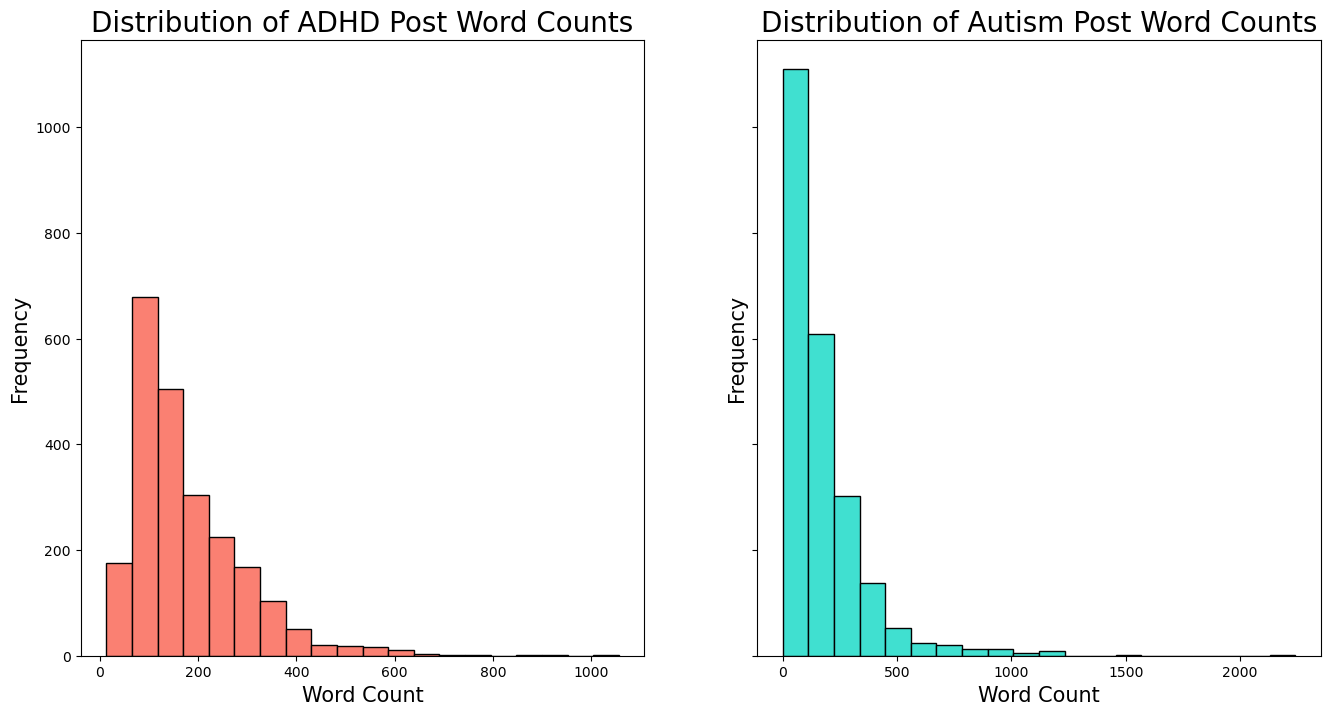

In [20]:
# create a subplot of word counts for both subreddits
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 8), sharey = True)

ax1.hist(subreddit_posts[subreddit_posts['subreddit'] == 0]['post_word_count'], \
         bins = 20, color = 'salmon', edgecolor = 'black')
ax1.set_xlabel('Word Count', fontsize = 15)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_title('Distribution of ADHD Post Word Counts', fontsize = 20)

ax2.hist(subreddit_posts[subreddit_posts['subreddit'] == 1]['post_word_count'], \
         bins = 20, color = 'turquoise', edgecolor = 'black')
ax2.set_xlabel('Word Count', fontsize = 15)
ax2.set_ylabel('Frequency', fontsize = 15)
ax2.set_title('Distribution of Autism Post Word Counts', fontsize = 20);

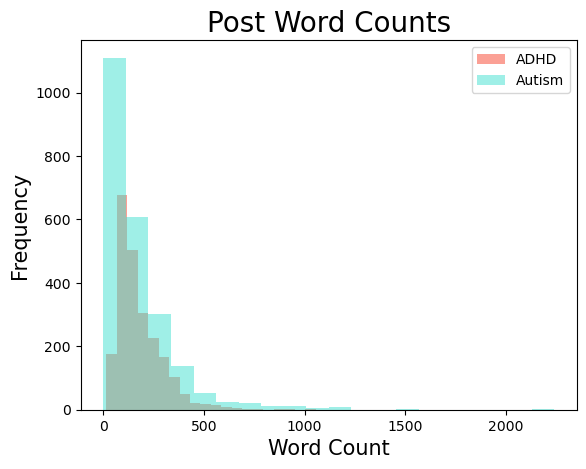

In [21]:
# create a histogram of word counts for both subreddits on the same axes
plt.hist(subreddit_posts[subreddit_posts['subreddit'] == 0]['post_word_count'], \
         bins = 20, alpha = 0.75, color = 'salmon')
plt.hist(subreddit_posts[subreddit_posts['subreddit'] == 1]['post_word_count'], \
         bins = 20, alpha = 0.5, color = 'turquoise');
plt.xlabel('Word Count', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.title('Post Word Counts', fontsize = 20)
plt.legend(['ADHD', 'Autism']);

In comparing the two subreddits, we can see that the word counts for ADHD and autism posts follow similar skewed right distributions. However, we can see that more of the autism posts have lower word counts. The autism posts also appear to have more high word count outliers than the ADHD posts.

Let us look at distributinons of the character length of posts now.

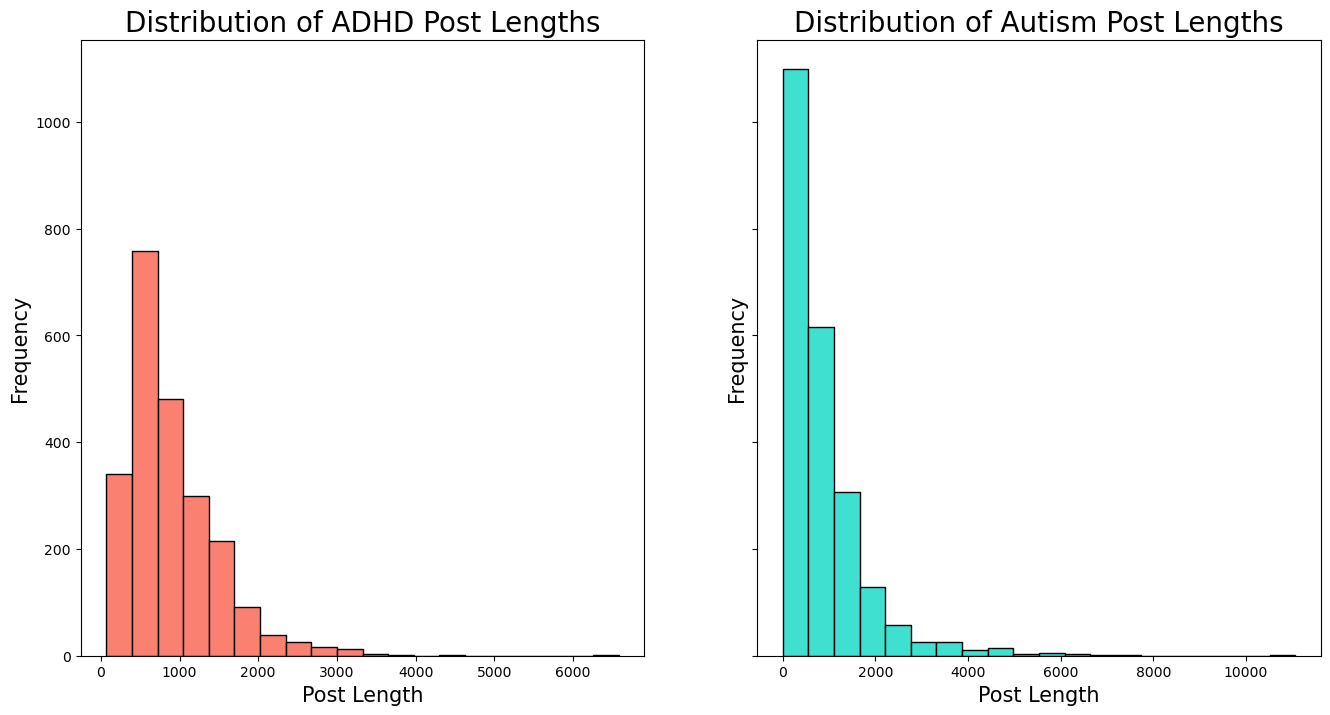

In [22]:
# create a subplot of post lengths for both subreddits
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 8), sharey = True)

ax1.hist(subreddit_posts[subreddit_posts['subreddit'] == 0]['post_length'], \
         bins = 20, color = 'salmon', edgecolor = 'black')
ax1.set_xlabel('Post Length', fontsize = 15)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_title('Distribution of ADHD Post Lengths', fontsize = 20)

ax2.hist(subreddit_posts[subreddit_posts['subreddit'] == 1]['post_length'], \
         bins = 20, color = 'turquoise', edgecolor = 'black')
ax2.set_xlabel('Post Length', fontsize = 15)
ax2.set_ylabel('Frequency', fontsize = 15)
ax2.set_title('Distribution of Autism Post Lengths', fontsize = 20);

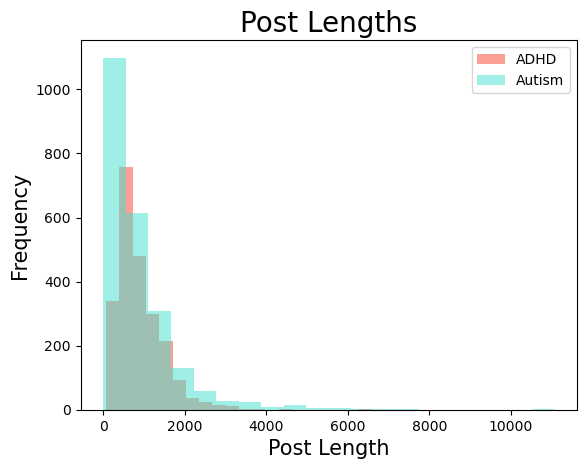

In [23]:
# create a histogram of post lengths for both subreddits on the same axes
plt.hist(subreddit_posts[subreddit_posts['subreddit'] == 0]['post_length'], \
         bins = 20, alpha = 0.75, color = 'salmon')
plt.hist(subreddit_posts[subreddit_posts['subreddit'] == 1]['post_length'], \
         bins = 20, alpha = 0.5, color = 'turquoise');
plt.xlabel('Post Length', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.title('Post Lengths', fontsize = 20)
plt.legend(['ADHD', 'Autism']);

Once again, a similar skewed right distribution holds for both subreddit posts in terms of character length. Just as above, the autism subreddit has more shorter or zero character length posts as well as more higher length outliers. Again, this may mean at the preprocessing our data stage, we might need to eliminate some of the most extreme outliers to build our baseline model.

Now, we can turn our attention to some word and phrase EDA.

---

## Word and Phrase EDA

In this next section, we will explore some of the most frequent words and phrases which appear in both of the ADHD and autism subreddits. We will look for words and phrases which stand out in each and scan for any for which there is some overlap. All of these will be investigated after removing English stop words. The goal will be start looking for potential stop words to include which would be specific to either ADHD or autism exlucisively or which invoke a medical as opposed to social model of disability. These particular words would be less useful for our purpose of modeling based on a lay person's description of their everyday, lived social experience.

We will begin just with a basic count vectorization to see the most frequent words before eliminating the common stop words and lemmatizing.

In [24]:
# instantiate CountVectorizer
cvec = CountVectorizer()

In [25]:
# declare X variable and fit and transform to CountVectorizer
X = subreddit_posts['selftext']

cvec.fit(X)

cvec_post = cvec.transform(X)

cvec_post

<4584x19074 sparse matrix of type '<class 'numpy.int64'>'
	with 441206 stored elements in Compressed Sparse Row format>

In [26]:
# creates new df from CountVectorizer
posts = pd.DataFrame(cvec_post.todense(),
                   columns = cvec.get_feature_names_out())

posts

,00,000,000th,00am,02,0200,0300,04,05g,07,...,zoom,zoomies,zooming,zyban,zyn,zzz,ďont,ľubovňa,𝐥𝐨𝐧𝐠,𝐬𝐨
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4580,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4581,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# displays top 15 most frequent words across both subreddits
posts.sum().sort_values(ascending = False).head(15)

to      25326
and     23962
the     17779
my      14352
it      14224
of      11235
that     9843
in       8367
but      8003
me       7953
for      7851
have     7510
is       7311
with     6930
this     6060
dtype: int64

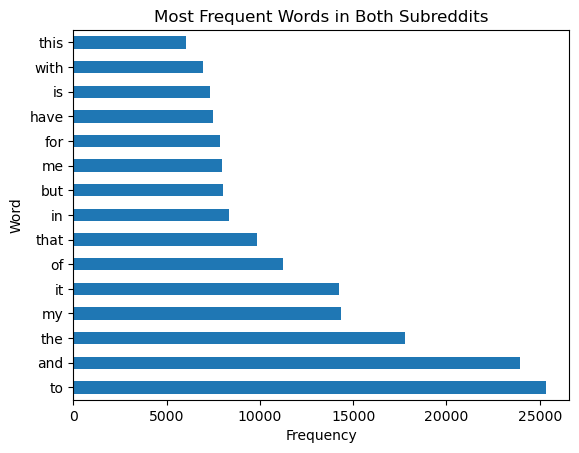

In [28]:
# displays a bar chart of the 15 most frequent words across both subreddits
posts.sum().sort_values(ascending = False).head(15).plot(kind = 'barh')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Most Frequent Words in Both Subreddits');

As suspected, the most frequent words across both subreddits are those contained in the stop words in the nltk library as English stop words, namely prepositions, pronouns, and determiners. Therefore, it makes more sense to instantiate the count vectorizer again, this time including the English stop words.

In [29]:
# instantiate CountVectorizer with English stop words
cvec = CountVectorizer(stop_words = 'english')

In [30]:
# declare X variable and fit and transform to CountVectorizer
X = subreddit_posts['selftext']

cvec.fit(X)

cvec_post = cvec.transform(X)

cvec_post

<4584x18776 sparse matrix of type '<class 'numpy.int64'>'
	with 257595 stored elements in Compressed Sparse Row format>

In [31]:
# creates new df from CountVectorizer
posts = pd.DataFrame(cvec_post.todense(),
                   columns = cvec.get_feature_names_out())

posts['subreddit'] = subreddit_posts['subreddit']

posts

,00,000,000th,00am,02,0200,0300,04,05g,07,...,zoom,zoomies,zooming,zyban,zyn,zzz,ďont,ľubovňa,𝐥𝐨𝐧𝐠,𝐬𝐨
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4580,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4581,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# displays top 15 most frequent words across both subreddits
posts.drop(columns = 'subreddit').sum().sort_values(ascending = False).head(15)

like      5356
just      5349
don       3355
feel      3032
ve        2999
know      2772
people    2519
adhd      2506
time      2495
really    2259
things    1948
want      1884
work      1583
think     1475
life      1414
dtype: int64

In [33]:
# displays top 30 most frequent words in ADHD subreddit
posts[posts['subreddit'] == 0].drop(columns = 'subreddit').sum().sort_values(ascending = False).head(30)

like         2704
just         2642
don          1699
feel         1525
ve           1477
know         1365
people       1284
time         1164
really       1120
adhd         1100
things        960
want          911
work          792
think         752
life          680
autism        610
need          593
day           590
going         580
autistic      580
lot           568
make          556
help          553
way           542
diagnosed     500
got           497
years         486
didn          466
did           444
good          432
dtype: int64

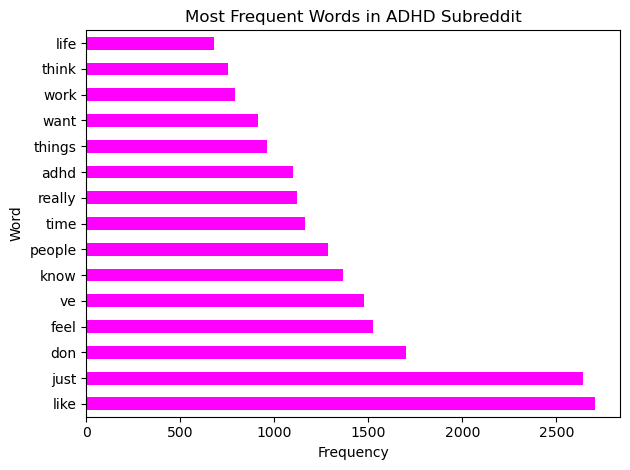

In [34]:
# displays a bar chart of the 15 most frequent words in ADHD subreddit
posts[posts['subreddit'] == 0].drop(columns = 'subreddit').sum().sort_values(ascending = False).head(15). \
plot(kind = 'barh', colormap = 'spring')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Most Frequent Words in ADHD Subreddit')
plt.tight_layout()
plt.savefig('./images/adhd_freq_words.png');

In [35]:
# displays top 30 most frequent words in autism subreddit
posts[posts['subreddit'] == 1].drop(columns = 'subreddit').sum().sort_values(ascending = False).head(30)

just         2403
like         2373
don          1441
ve           1364
feel         1341
adhd         1281
know         1260
time         1207
people       1074
really       1020
things        879
want          851
work          698
life          661
day           655
think         648
help          560
lot           541
diagnosed     523
need          522
autism        517
make          501
autistic      498
got           497
going         485
way           483
years         438
good          434
doing         422
having        409
dtype: int64

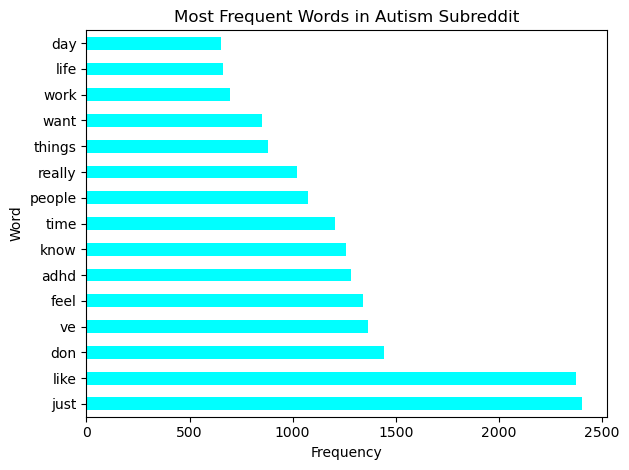

In [36]:
# displays a bar chart of the 15 most frequent words in autism subreddit
posts[posts['subreddit'] == 1].drop(columns = 'subreddit').sum().sort_values(ascending = False).head(15). \
plot(kind = 'barh', colormap = 'cool')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Most Frequent Words in Autism Subreddit')
plt.tight_layout()
plt.savefig('./images/autism_freq_words.png');

Looking at the second run through the count vectorizer, which excluded English stop words, we are starting to see some more ADHD and autism specific words pop up on both subreddits which may be important to add to a list of stop words for the purposes of our preliminary model later.

First, when we look at both subreddits, they both include the remainders of some contractions which are not getting caught in the English stop words, specifically "don" from the word "don't" and "ve" from the contracted words with the affix "'ve." Therefore, we will attempt to add these specific contractions as stop words.

The reader will note that this subsequent investigation of stop words was accurate up until the final iteration of data collection, so some of the most frequent words have changed. We felt it was necessary to keep in these stop words for our analysis, as they were showing up quite frequently until the day before the close of this investigation. Please continue reading the discussion below for further explanation.

The most obvious potential stop word on the ADHD subreddit is "adhd," but when we look at the 30 most frequent words in the days prior, we also saw some others we considered adding to our stop words later, including "medication," "diagnosed," and "meds." Since our problem statement is focused on neurodiverse people who may not know whether they are living with ADHD or autism, medication may or may not be a common theme to explore in our model. Diagnosis could be considered to include or leave out of the stop words since many people with autism also seek and talk about diagnosis.

Regarding the autism subreddit, it appears that it would make sense to include the words "autism" and "autistic" among our stop words as they are are too specific to the text. No other words stand out to include just yet.

At this point, we can conclude that "don," "ve," "adhd," "autism," and "autistic" may be safely included as stop words for our model. "Medication" and "meds" appear frequently in the ADHD subreddit, so it is probably also safe to assume that we can include these in the stop words, as they are a specific topic to ADHD but not autism and as our problem statement is focused on the testimony of a neurodiverse novice who will likely not be discussing medication until after receiving or on the path to receiving a diagnosis. Lastly, we can keep "diagnosed" for now because it appears frequent across both subreddits, albeit more in ADHD than in autism, and a novice may be discussing diagnosis as an issue of concern. The phenomonen of seeking diagnosis to gain access to medical care and treatment, education and employment accommodations, and access to public amenities leads us to believe that pondering diagnosis, even for a novice, is common enough to the neurodiverse experienced (and common to both of these subreddits) that it warrants keeping "diagnosed" in our model features.

Let's build a more inclusive list of stop words in our EDA ongoing.

In [37]:
new_stop_words = stopwords.words('english')
incl_stop_words = ['don', 've', 'autism', 'autistic', 'adhd', 'medication', 'meds']
for word in incl_stop_words:
    new_stop_words.append(word)

Moving forward, we will conduct one more count vectorizer this time after lemmatizing the sample space and using our larger list of stop words specific to our investigation and problem statement.

In [38]:
# instantiate lemmatizer
lemmatizer = WordNetLemmatizer()

In [39]:
# tokenize each of the selftext posts by word tokens
tokens_words = [word_tokenize(word) for word in subreddit_posts['selftext']]

# lemmatize each of the selftext posts by a nested list comprehension
subreddit_posts['selftext_lemma'] = [' '.join([lemmatizer.lemmatize(word) for word in post]) \
                                     for post in tokens_words]

# print df with new lemma column
subreddit_posts

,title,selftext,subreddit,post_word_count,post_length,selftext_lemma
0,Megathread: US Medication Shortage,as many of you are aware by now the current u ...,0,319,2033,a many of you are aware by now the current u s...
1,Did you do something you're proud of? Somethin...,what success have you had this week did you ac...,0,52,288,what success have you had this week did you ac...
2,The Vyvanse poops have taken over my mornings..,i now wake up at least 1 5 hours early to ensu...,0,85,379,i now wake up at least 1 5 hour early to ensur...
3,Why does someone forcing you to push through e...,i can t even explain how it hurts but it s so ...,0,62,304,i can t even explain how it hurt but it s so m...
4,Just had an epiphany- isn’t it crazy how relig...,so my mom can believe in all her saints god je...,0,175,897,so my mom can believe in all her saint god jes...
...,...,...,...,...,...,...
4863,Scared of old people,anyone else scared of old people when i talk t...,1,77,398,anyone else scared of old people when i talk t...
4864,Recommendations for blocking out noise for sleep,i have a really hard time sleeping due to even...,1,116,588,i have a really hard time sleeping due to even...
4865,Mom Refuses Access to Diagnosis Report,i 17f was diagnosed with autism and adhd aroun...,1,83,403,i 17f wa diagnosed with autism and adhd around...
4866,Do you feel uncomfortable with everyday sounds?,i m talking about inevitable sounds as birds d...,1,204,1067,i m talking about inevitable sound a bird dog ...


We have now created lemmatized text for each of the posts. Now, we can identify the most common words after lemmatizing to see if they have changed in comparison to comparing just the cleaned text without basic English stop words.

In [40]:
# instantiate CountVectorizer with English stop words
cvec = CountVectorizer(stop_words = new_stop_words)

# declare X variable and fit and transform to CountVectorizer
X = subreddit_posts['selftext_lemma']

cvec.fit(X)

cvec_lem = cvec.transform(X)

cvec_lem

<4584x16817 sparse matrix of type '<class 'numpy.int64'>'
	with 283007 stored elements in Compressed Sparse Row format>

In [41]:
# creates new df from CountVectorizer
posts_lem = pd.DataFrame(cvec_lem.todense(),
                   columns = cvec.get_feature_names_out())

posts_lem['subreddit'] = subreddit_posts['subreddit']

posts_lem

,00,000,000th,00am,02,0200,0300,04,05g,07,...,zoom,zoomies,zooming,zyban,zyn,zzz,ďont,ľubovňa,𝐥𝐨𝐧𝐠,𝐬𝐨
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4580,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4581,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
# displays top 15 most frequent words across both lemmatized subreddits
posts_lem.drop(columns = 'subreddit').sum().sort_values(ascending = False).head(15)

wa        5447
like      5410
feel      3569
get       3444
time      2952
know      2881
thing     2816
people    2543
really    2259
even      2064
want      2026
ha        2024
day       1910
would     1892
one       1838
dtype: int64

In [43]:
# displays top 30 most frequent lemmatized words in ADHD subreddit
posts_lem[posts_lem['subreddit'] == 0].drop(columns = 'subreddit').sum().sort_values(ascending = False).head(30)

like         2732
wa           2692
feel         1772
get          1660
know         1427
time         1393
thing        1388
people       1295
really       1120
even         1006
want          981
ha            967
would         952
one           915
day           887
work          874
make          858
also          851
something     840
year          838
think         793
much          723
go            709
need          703
life          702
anyone        697
help          633
way           621
lot           607
going         581
dtype: int64

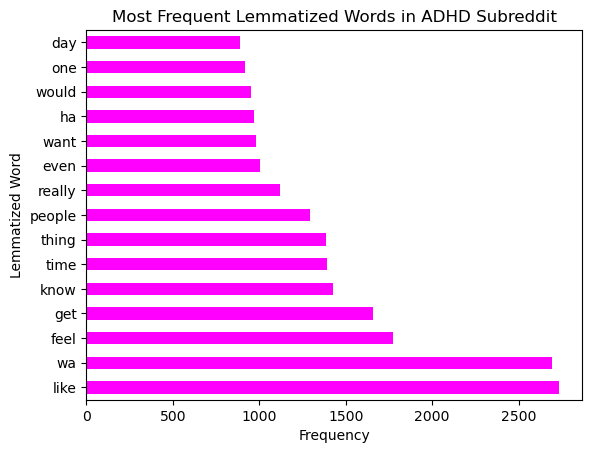

In [44]:
# displays a bar chart of the 15 most frequent lemmatized words in ADHD subreddit
posts_lem[posts_lem['subreddit'] == 0].drop(columns = 'subreddit').sum().sort_values(ascending = False).head(15). \
plot(kind = 'barh', colormap = 'spring')
plt.xlabel('Frequency')
plt.ylabel('Lemmatized Word')
plt.title('Most Frequent Lemmatized Words in ADHD Subreddit');

In [45]:
# displays top 30 most frequent lemmatized words in autism subreddit
posts_lem[posts_lem['subreddit'] == 1].drop(columns = 'subreddit').sum().sort_values(ascending = False).head(30)

wa           2472
like         2396
get          1604
feel         1602
time         1410
know         1301
thing        1257
people       1084
really       1020
ha            961
even          948
day           927
want          914
would         837
one           822
year          809
also          797
make          778
work          777
think         696
something     693
life          684
anyone        643
need          640
help          640
much          631
go            623
take          598
lot           569
always        549
dtype: int64

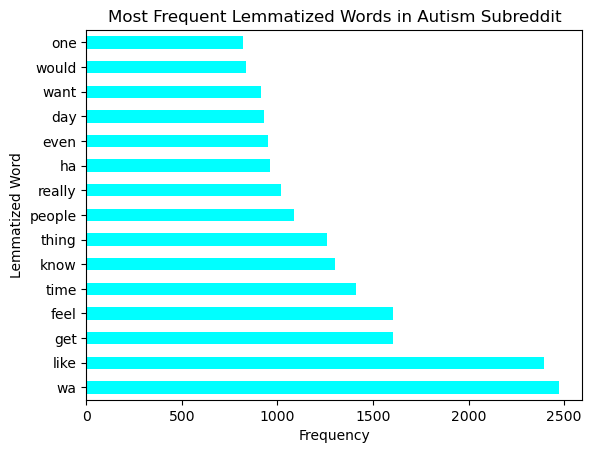

In [46]:
# displays a bar chart of the 15 most frequent lemmatized words in autism subreddit
posts_lem[posts_lem['subreddit'] == 1].drop(columns = 'subreddit').sum().sort_values(ascending = False).head(15). \
plot(kind = 'barh', colormap = 'cool')
plt.xlabel('Frequency')
plt.ylabel('Lemmatized Word')
plt.title('Most Frequent Lemmatized Words in Autism Subreddit');

Comparing the top most frequent lemmatized words with the original words in the posts, there appears to be very little difference in which words are most frequent. The only noticeable exception in terms of word frequency is that now the most common word in the autism subreddit is "wa," which is likely a lemmatized form of "was." This does not appear to add much value to our models moving forward. Therefore, it is probably safe to assume that lemmatizing may not be useful for our modeling moving forward. We will compare the lemmatized words with our regular count vectorized words in our preliminary model later.

One last step here will be to investigate the most common phrases in terms of bigrams to see if any might show up as common stop words in our models or if any stand out to maintain in our models.

In [47]:
# declare X variable as bigrams and fit and transform to CountVectorizer
X_bi = subreddit_posts['selftext']

cvec_bi = CountVectorizer(stop_words = new_stop_words, ngram_range = (2, 2))

cvec_bi.fit(X_bi)

X_bigrams = cvec_bi.transform(X_bi)

In [48]:
# creates new df from CountVectorizer
bi_posts = pd.DataFrame(X_bigrams.todense(),
                        columns = cvec_bi.get_feature_names_out())

bi_posts['subreddit'] = subreddit_posts['subreddit']

bi_posts

,00 00,00 15,00 6pm,00 even,00 get,00 left,00 possible,00 really,00 went,000 13,...,zooming opinion,zyban literally,zyn pouch,zyn stimulants,zzz quil,ďont want,ľubovňa stadium,𝐥𝐨𝐧𝐠 want,𝐬𝐨 𝐥𝐨𝐧𝐠,subreddit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4580,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4581,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [49]:
# displays top 15 most frequent bigrams across both subreddits
bi_posts.drop(columns = 'subreddit').sum().sort_values(ascending = False).head(15)

feel like         1122
anyone else        479
feels like         287
even though        192
mental health      185
things like        163
felt like          152
every time         151
last year          137
something else     130
got diagnosed      130
first time         128
side effects       125
years ago          123
would like         122
dtype: int64

In [50]:
# displays top 30 most frequent bigrams in ADHD subreddit
bi_posts[bi_posts['subreddit'] == 0].drop(columns = 'subreddit').sum().sort_values(ascending = False).head(30)

feel like           537
anyone else         246
feels like          130
even though          87
mental health        84
things like          79
something else       74
felt like            72
every time           67
last year            66
got diagnosed        62
eye contact          61
makes feel           60
would like           59
whole life           59
first time           58
years ago            57
hard time            55
side effects         54
high school          54
years old            52
special interest     51
seems like           49
months ago           49
something like       49
go back              48
every single         46
every day            45
really hard          44
really want          44
dtype: int64

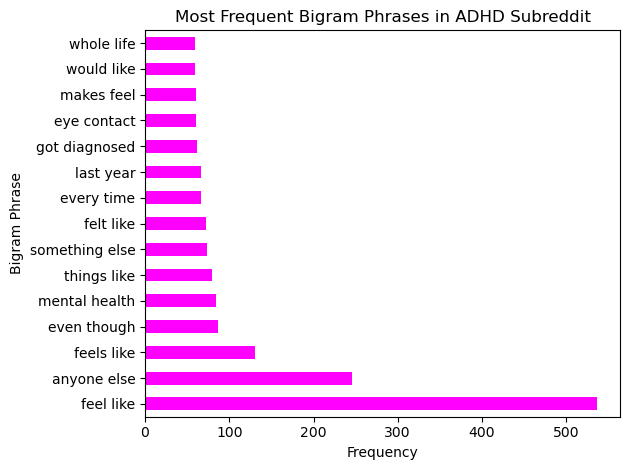

In [51]:
# displays a bar chart of the 15 most frequent bigrams in ADHD subreddit
bi_posts[bi_posts['subreddit'] == 0].drop(columns = 'subreddit').sum().sort_values(ascending = False).head(15). \
plot(kind = 'barh', colormap = 'spring')
plt.xlabel('Frequency')
plt.ylabel('Bigram Phrase')
plt.title('Most Frequent Bigram Phrases in ADHD Subreddit')
plt.tight_layout()
plt.savefig('./images/adhd_bigrams.png');

In [52]:
# displays top 30 most frequent bigrams in autism subreddit
bi_posts[bi_posts['subreddit'] == 1].drop(columns = 'subreddit').sum().sort_values(ascending = False).head(30)

feel like             525
anyone else           206
feels like            140
even though            95
mental health          91
every time             79
felt like              68
things like            68
last year              66
first time             63
got diagnosed          63
side effects           61
every day              61
years ago              58
months ago             56
long time              52
hard time              52
would like             52
something else         51
feeling like           51
years old              50
year old               50
recently diagnosed     47
makes feel             44
wondering anyone       43
high school            42
really want            41
like know              41
every single           40
even know              39
dtype: int64

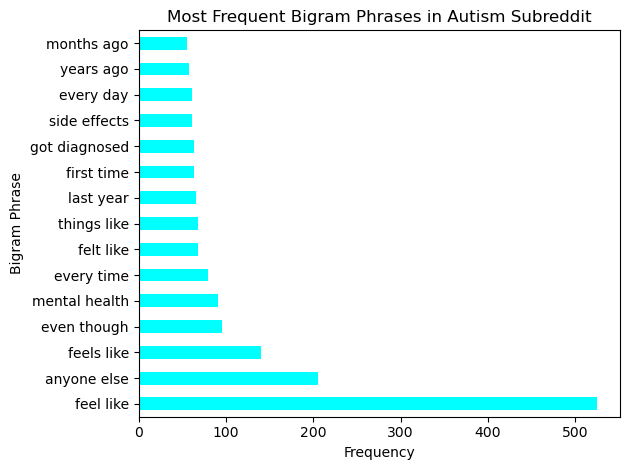

In [53]:
# displays a bar chart of the 15 most frequent bigrams in autism subreddit
bi_posts[bi_posts['subreddit'] == 1].drop(columns = 'subreddit').sum().sort_values(ascending = False).head(15). \
plot(kind = 'barh', colormap = 'cool')
plt.xlabel('Frequency')
plt.ylabel('Bigram Phrase')
plt.title('Most Frequent Bigram Phrases in Autism Subreddit')
plt.tight_layout()
plt.savefig('./images/autism_bigrams.png');

The bigram phrases are very revealing because we can now see some more patterns emerge in terms of both overlap and that which separates the two subreddits. Both subreddits show more disucssion of diagnosis. We may be able to eliminate the word "diagnosed" as a stop word since our problem statement is concerned with a social model of disability instead of a medical model of disability. However, a novice neurodiverse person may write about the desire to receive diagnosis and there is some difference in frequency between the two subreddits. Additionally, both subreddits discuss "mental health" at high but slightly different frequency.

The specific differences appear to show up in more in the most frequent autism phrases, specifically "eye contact" and "sensory issues." Since these are potentially ways in which a lay person may describe their experience with autism, we would argue to keep these words or phrases in the baseline model. Looking at these most frequent bigram phrases, we see only a little overlap in terms of phrases which may show up more frequently with lemmatization such as "feel like" vs. "feels like." Therefore, we believe it is unnecessary to investigate lemmatized bigrams for the purposes of our model.

Next, we will do some exploratory data analysis of the sentiments of posts in each of the subreddits.

---

## Sentiment Analysis

We will next look at the overall sentiment analysis of the posts in both subreddits.

In [54]:
# Instantiate Sentiment Intensity Analyzer
sent = SentimentIntensityAnalyzer()

In [55]:
# creates new column with sentiment composite score for each post
subreddit_posts['sentiment'] = [sent.polarity_scores(post)['compound'] for post in subreddit_posts['selftext']]

subreddit_posts

,title,selftext,subreddit,post_word_count,post_length,selftext_lemma,sentiment
0,Megathread: US Medication Shortage,as many of you are aware by now the current u ...,0,319,2033,a many of you are aware by now the current u s...,-0.9567
1,Did you do something you're proud of? Somethin...,what success have you had this week did you ac...,0,52,288,what success have you had this week did you ac...,0.9633
2,The Vyvanse poops have taken over my mornings..,i now wake up at least 1 5 hours early to ensu...,0,85,379,i now wake up at least 1 5 hour early to ensur...,0.6124
3,Why does someone forcing you to push through e...,i can t even explain how it hurts but it s so ...,0,62,304,i can t even explain how it hurt but it s so m...,-0.8755
4,Just had an epiphany- isn’t it crazy how relig...,so my mom can believe in all her saints god je...,0,175,897,so my mom can believe in all her saint god jes...,-0.9856
...,...,...,...,...,...,...,...
4863,Scared of old people,anyone else scared of old people when i talk t...,1,77,398,anyone else scared of old people when i talk t...,-0.7933
4864,Recommendations for blocking out noise for sleep,i have a really hard time sleeping due to even...,1,116,588,i have a really hard time sleeping due to even...,-0.6284
4865,Mom Refuses Access to Diagnosis Report,i 17f was diagnosed with autism and adhd aroun...,1,83,403,i 17f wa diagnosed with autism and adhd around...,-0.4019
4866,Do you feel uncomfortable with everyday sounds?,i m talking about inevitable sounds as birds d...,1,204,1067,i m talking about inevitable sound a bird dog ...,0.3574


In [56]:
# shows summary statistics of sentiment scores
subreddit_posts['sentiment'].describe()

count    4584.000000
mean        0.166767
std         0.737135
min        -0.999200
25%        -0.611275
50%         0.400950
75%         0.888575
max         0.999300
Name: sentiment, dtype: float64

In [57]:
# shows summary statistics of sentiment scores for ADHD subreddit
subreddit_posts[subreddit_posts['subreddit'] == 0]['sentiment'].describe()

count    2286.000000
mean        0.166354
std         0.746570
min        -0.997900
25%        -0.636900
50%         0.442050
75%         0.894450
max         0.999100
Name: sentiment, dtype: float64

In [58]:
# shows summary statistics of sentiment scores for autism subreddit
subreddit_posts[subreddit_posts['subreddit'] == 1]['sentiment'].describe()

count    2298.000000
mean        0.167179
std         0.727790
min        -0.999200
25%        -0.585250
50%         0.352850
75%         0.881375
max         0.999300
Name: sentiment, dtype: float64

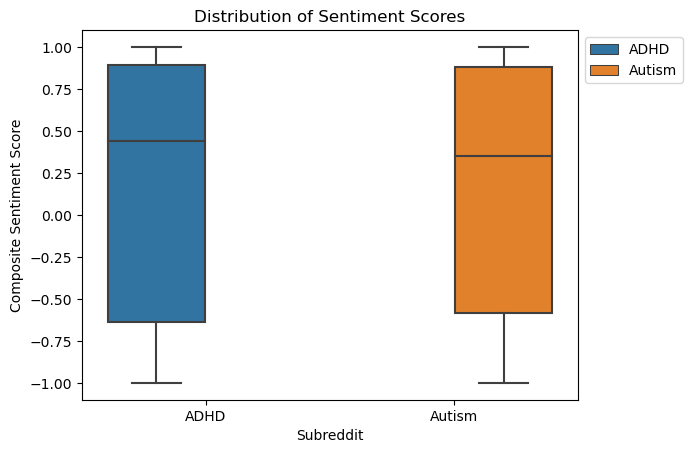

<Figure size 640x480 with 0 Axes>

In [59]:
# shows boxplots of sentiment scores for both subreddits
ax = sns.boxplot(x='subreddit', y='sentiment', hue='subreddit', data=subreddit_posts) 
plt.xlabel('Subreddit')
plt.ylabel('Composite Sentiment Score')
plt.title('Distribution of Sentiment Scores')
plt.xticks(labels = ['ADHD', 'Autism'], ticks = ax.get_xticks())
plt.legend(ax.get_legend_handles_labels()[0], ['ADHD', 'Autism'], bbox_to_anchor = (1, 1))
plt.show()
plt.tight_layout()
plt.savefig('./images/sentiment_scores.png');

Based on the summary statistics and boxplots above, we can see that both subreddits have a similar range of negative to positive sentiment. Also, the center and spread of the composite sentiment scores are really similar with the autism subreddit having a slightly lower median score. This indicates that the two subreddits probably have a high degree of commonality in the connotations of language used, making the classification model more imperative to try to tease out the difference between the two.

We will conclude this notebook by saving our csv file with added columns.

In [60]:
# saves cleaned subreddit df to new csv file
subreddit_posts.to_csv('./data_files/sr_posts_cleaned.csv', index = False)

---

## Notebook Conclusion

In this notebook, we cleaned our data by dropping duplicates, cleaned the selftext of posts, and added new columns in our exploratory data analysis. We also explored the lengths of posts, the frequency of words and phrases, and the sentiments of each of the subreddits.

In Part 4, we can use this information to jump into preprocessing our data for modeling by generating a few baseline models in which we explore a few different stop words to include.